#import every needed Library 


In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 26.5 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=18f714baadf659adb58162bcabefc933361735cb8dca4d15589ca290c3017796
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [ ]:
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.feature_selection import r_regression

# from langdetect import detect


#loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CURR_PATH = !pwd
# PARAMETERS
PATH_DATA = CURR_PATH[0]
PATH_GDRIVE_TMP = "/content/drive/MyDrive/ML/project2"  # Google Drive

##detect language 

In [ ]:
def detect2(x):
  try:
    return detect(x)
  except:
    return None

##loading training list

In [ ]:
import pickle
import pandas as pd
with open('/content/drive/MyDrive/ML/project2/listings.pkl', 'rb') as f:
    data = pickle.load(f) 
#combine description
data['Listing Description'] = data['Listing Title'] + '.' + data['Listing Description']
i = data['Listing Description'].isna()
data.loc[i,'Listing Description']= data.loc[i,'Listing Title']

In [ ]:
#language classify
data['Description Langage']=data['Listing Description'].apply(lambda x: detect2(x))
print(len(data))
#save data with language tag
pickle.dump(data, open(PATH_GDRIVE_TMP + "/data_with_language.pkl", "wb"))
data['Description Langage'].value_counts ()

20000


de    16361
fr     3206
it      425
pt        2
hr        1
en        1
ca        1
da        1
so        1
sl        1
Name: Description Langage, dtype: int64

###for building model

In [ ]:
#only use description length more than 100 characters
data = pickle.load(open(PATH_GDRIVE_TMP+"/data_with_language.pkl", "rb"))
data_de = data.loc[data['Description Langage'] == 'de', ("Listing Description","Listing Title","Demand")]
data_fr = data.loc[data['Description Langage'] == 'fr', ("Listing Description","Listing Title","Demand")]
data_it = data.loc[data['Description Langage'] == 'it', ("Listing Description","Listing Title","Demand")]
print("before filter:",len(data_fr))
data_fr = data_fr[data_fr["Listing Description"].apply(len)>100]
print(len(data_de))
print("after filter:",len(data_fr))
print(len(data_it))
print(len(data_de)+len(data_fr)+len(data_it))

fr1: 3206
16361
fr2: 3195
425
19981


In [ ]:
data_de.columns = ['description', 'title', 'demand']
data_fr.columns = ['description', 'title', 'demand']
data_it.columns = ['description', 'title', 'demand']
df_de, val_data_de = train_test_split(data_de, test_size=0.2, random_state=18)
df_fr, val_data_fr = train_test_split(data_fr, test_size=0.2, random_state=18)
df_it, val_data_it = train_test_split(data_it, test_size=0.2, random_state=18)
# print(df_de.head(2))
# print(df_fr.head(2))
# print(df_it.head(2))

##loading testing listing

In [ ]:
import pickle
import pandas as pd
# pickle.dump(data, open(PATH_GDRIVE_TMP + "/data_with_language.pkl", "wb"))
with open('/content/drive/MyDrive/ML/project2/test_listings_overall.pkl', 'rb') as f:
    data = pickle.load(f) 
data['Listing Description'] = data['Listing Title'] + '.' + data['Listing Description']
i = data['Listing Description'].isna()
data.loc[i,'Listing Description']= data.loc[i,'Listing Title']

In [ ]:
data['Description Langage']=data['Listing Description'].apply(lambda x: detect2(x))
print(len(data))
pickle.dump(data, open(PATH_GDRIVE_TMP + "/test_data_with_language.pkl", "wb"))
data['Description Langage'].value_counts ()

10000


de    8211
fr    1554
it     234
Name: Description Langage, dtype: int64

###for testing

In [ ]:
# data = pickle.load(open(PATH_GDRIVE_TMP+"/test_data_with_language.pkl", "rb"))
# data = pickle.load(open(PATH_GDRIVE_TMP+"/test_overall_data_with_language.pkl", "rb"))
data_de = data.loc[data['Description Langage'] == 'de', ("Listing Description","Listing Title","Prediction")]
data_fr = data.loc[data['Description Langage'] == 'fr', ("Listing Description","Listing Title","Prediction")]
data_it = data.loc[data['Description Langage'] == 'it', ("Listing Description","Listing Title","Prediction")]
print(len(data_fr))
data_fr = data_fr[data_fr["Listing Description"].apply(len)>100]
print(len(data_de))
print(len(data_fr))
print(len(data_it))
print(len(data_de)+len(data_fr)+len(data_it))

1554
8212
1554
234
10000


In [ ]:
data_de.columns = ['description', 'title', 'Prediction']
data_fr.columns = ['description', 'title', 'Prediction']
data_it.columns = ['description', 'title', 'Prediction']
df_de = data_de
df_fr = data_fr
df_it = data_it
print(df_de.head(2))
print(df_fr.head(2))
print(df_it.head(2))

#data processing 

##clean1

*   Converting text to lower-case
*   Standardising representations of a same entity such as “€”, “euro” and “euros” or “m2” and “m²”,
*   Cleaning out certain patterns that are unlikely to be meaningful such as URLs, phone numbers, emails and bank account references.

In [ ]:
import re
def treat_euro(text):
    text = re.sub(r'(euro[^s])|(euros)|(€)', ' euros', text)
    return text
def treat_m2(text):
    text = re.sub(r'(m2)|(m²)', ' m²', text)
    return text

In [ ]:
def filter_ibans(text):
    pattern = r'fr\d{2}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{2}|fr\d{20}|fr[ ]\d{2}[ ]\d{3}[ ]\d{3}[ ]\d{3}[ ]\d{5}'
    text = re.sub(pattern, '', text)
    return text
def remove_space_between_numbers(text):
    text = re.sub(r'(\d)\s+(\d)', r'\1\2', text)
    return text
def filter_emails(text):
    pattern = r'(?:(?!.*?[.]{2})[a-zA-Z0-9](?:[a-zA-Z0-9.+!%-]{1,64}|)|\"[a-zA-Z0-9.+!% -]{1,64}\")@[a-zA-Z0-9][a-zA-Z0-9.-]+(.[a-z]{2,}|.[0-9]{1,})'
    text = re.sub(pattern, '', text)
    return text
def filter_ref(text):
    pattern = r'(\(*)(ref|réf)(\.|[ ])\d+(\)*)'
    text = re.sub(pattern, '', text)
    return text
def filter_websites(text):
    pattern = r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*'
    text = re.sub(pattern, '', text)
    return text
def filter_phone_numbers(text):
    pattern = r'(?:(?:\+|00)33[\s.-]{0,3}(?:\(0\)[\s.-]{0,3})?|0)[1-9](?:(?:[\s.-]?\d{2}){4}|\d{2}(?:[\s.-]?\d{3}){2})|(\d{2}[ ]\d{2}[ ]\d{3}[ ]\d{3})'
    text = re.sub(pattern, '', text)
    return text
def filter_tag(text):
    pattern = r'<[^>]+>'
    text = re.sub(pattern, '', text)
    return text

In [ ]:
def clean_text(text):
    text = text.lower()
    text = text.replace(u'\xa0', u' ')
    text = treat_m2(text)
    text = treat_euro(text)
    text = filter_phone_numbers(text)
    text = filter_emails(text)
    text = filter_ibans(text)
    text = filter_ref(text)
    text = filter_websites(text)
    text = remove_space_between_numbers(text)
    text = filter_tag(text)
    return text
df_fr['cleaned_description'] = df_fr.description.apply(clean_text)

##clean2
only in case of dealing stop word (which is not necessary in this task

###for french

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("french")
stop_words = set(stopwords.words("french"))


def clean_text_fr(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

df_fr['cleaned_description'] = df_fr.description.apply(clean_text_fr)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
len(df_fr)

1554

In [ ]:
df_fr

###for Italian

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("italian")
stop_words = set(stopwords.words("italian"))


def clean_text_it(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

df_it['cleaned_description'] = df_it.description.apply(clean_text_it)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


###for german

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))

def clean_text_de(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

df_de['cleaned_description'] = df_de.description.apply(clean_text_de)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#French model

##Tokenization

In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
from transformers import CamembertModel, CamembertTokenizer

In [ ]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

Downloading:   0%|          | 0.00/811k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

In [ ]:
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
encoded_corpus = tokenizer(text=df_fr.cleaned_description.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)
input_ids = encoded_corpus['input_ids']
attention_mask = encoded_corpus['attention_mask']

In [ ]:
import numpy as np
def filter_long_descriptions(tokenizer, descriptions, max_len):
    indices = []
    lengths = tokenizer(descriptions, padding=False, 
                     truncation=False, return_length=True)['length']
    for i in range(len(descriptions)):
        if lengths[i] <= max_len-2:
            indices.append(i)
    return indices
short_descriptions = filter_long_descriptions(tokenizer, 
                               df_fr.cleaned_description.tolist(), 300)
input_ids = np.array(input_ids)[short_descriptions]
attention_mask = np.array(attention_mask)[short_descriptions]
labels = df_fr.demand.to_numpy()[short_descriptions]

Token indices sequence length is longer than the specified maximum sequence length for this model (775 > 512). Running this sequence through the model will result in indexing errors


##Input formatting

###for train

In [ ]:
from sklearn.model_selection import train_test_split
test_size = 0.1
seed = 64
train_inputs, test_inputs, train_labels, test_labels = \
            train_test_split(input_ids, labels, test_size=test_size, 
                             random_state=seed)
train_masks, test_masks, _, _ = train_test_split(attention_mask, 
                                        labels, test_size=test_size, 
                                        random_state=seed)

###for testing

In [ ]:
train_inputs = input_ids
train_masks = attention_mask

##create_dataloaders

###train dataloader

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, 
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader
train_dataloader = create_dataloaders(train_inputs, train_masks, 
                                      train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks, 
                                     test_labels, batch_size)

###test dataloader

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32
def create_dataloaders(inputs, masks, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    dataset = TensorDataset(input_tensor, mask_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader
train_dataloader = create_dataloaders(train_inputs, train_masks, batch_size)

##Implementing the model in PyTorch

In [ ]:
import torch.nn as nn
from transformers import CamembertModel
class CamembertRegressor(nn.Module):
    
    def __init__(self, drop_rate=0.2, freeze_camembert=False):
        
        super(CamembertRegressor, self).__init__()
        D_in, D_out = 768, 1
        # D_in2, D_out2 = 1536 ,1
        self.camembert = \
                   CamembertModel.from_pretrained('camembert-base')
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out),
            # nn.Sigmoid(),
            # nn.Dropout(drop_rate),
            # nn.Linear(D_in2, D_out2),
            # nn.ReLU()
            )
    def forward(self, input_ids, attention_masks):
        
        outputs = self.camembert(input_ids, attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs
model = CamembertRegressor(drop_rate=0.2)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##Setting up the training environment

In [ ]:
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
model.to(device)

##Optimizer, scheduler and loss function

In [ ]:
from transformers import AdamW
# from torch.optim import RAdam
# from torch.optim import SGD
# optimizer = SGD(model.parameters(), lr=1e-5)
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)
# optimizer = RAdam(model.parameters(),
#                   lr=2e-5)

In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 50
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,       
                 num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
from torch import nn
loss_function = nn.MSELoss()
# loss_function = nn.PoissonNLLLoss()

##Training loop

In [ ]:
from torch.nn.utils.clip_grad import clip_grad_norm
def train(model, optimizer, scheduler, loss_function, epochs, 
          train_dataloader, device, clip_value=2):
    for epoch in range(epochs):
        # list1 = []
        print(epoch)
        print("-----")
        best_loss = 1e10
        model.train()
        for step, batch in enumerate(train_dataloader):  
            batch_inputs, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)           
            loss = loss_function(outputs.squeeze().float(), 
                             batch_labels.squeeze().float())
            print(f'step:{step}, loss:{loss}') 
            # list1.append(loss)
            loss.backward()
            clip_grad_norm(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
        # lost_list.append(list1)

    return model
lost_list = [[]]
model = train(model, optimizer, scheduler, loss_function, epochs, train_dataloader, device)

0
-----
step:0, loss:58.077796936035156


<ipython-input-39-be6f69454809>:20: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  clip_grad_norm(model.parameters(), clip_value)


step:1, loss:80.8313980102539
step:2, loss:60.55558776855469
step:3, loss:91.92435455322266
step:4, loss:96.04283142089844
step:5, loss:14.005131721496582
step:6, loss:42.97001647949219
step:7, loss:50.27099609375
step:8, loss:117.72444152832031
step:9, loss:215.45034790039062
step:10, loss:115.28955841064453
step:11, loss:19.153955459594727
step:12, loss:17.362031936645508
step:13, loss:45.41661834716797
step:14, loss:39.768638610839844
step:15, loss:13.67514705657959
step:16, loss:20.485519409179688
step:17, loss:36.66682815551758
step:18, loss:40.55812072753906
step:19, loss:105.08653259277344
step:20, loss:45.955162048339844
step:21, loss:23.11153221130371
step:22, loss:16.624839782714844
step:23, loss:21.738676071166992
step:24, loss:135.15516662597656
step:25, loss:24.59214973449707
step:26, loss:16.41219711303711
step:27, loss:12.522788047790527
step:28, loss:56.47816467285156
step:29, loss:14.219366073608398
step:30, loss:29.098634719848633
step:31, loss:59.12055969238281
step:

#Performance

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, _ = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs, 
                            batch_masks).view(1,-1).tolist()[0]
    return output

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
val_set = val_data_fr[['description', 'demand']]
val_set['cleaned_description'] = \
                val_set.description.apply(clean_text)
encoded_val_corpus = \
                tokenizer(text=val_set.cleaned_description.tolist(),
                          add_special_tokens=True,
                          padding='max_length',
                          truncation='longest_first',
                          max_length=300,
                          return_attention_mask=True)
val_input_ids = np.array(encoded_val_corpus['input_ids'])
val_attention_mask = np.array(encoded_val_corpus['attention_mask'])
val_labels = val_set.demand.to_numpy()
val_dataloader = create_dataloaders(val_input_ids, 
                         val_attention_mask, val_labels, batch_size)
y_pred = predict(model, val_dataloader, device)
y_test = val_set.demand.to_numpy()

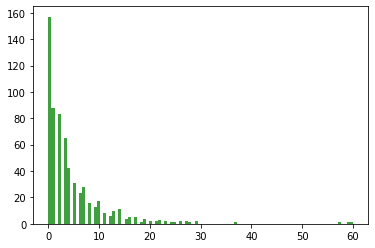

In [ ]:
import matplotlib.pyplot as plt
# n = data["comment_clean"].str.len()
nn, bins, patches = plt.hist(y_test,100, facecolor ='g', alpha=0.75)
plt.show()

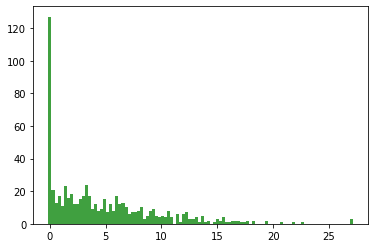

In [ ]:
import matplotlib.pyplot as plt
# n = data["comment_clean"].str.len()
nn, bins, patches = plt.hist(y_pred,100, facecolor ='g', alpha=0.75)
plt.show()

###r_squared

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mdape = ((pd.Series(y_test) - pd.Series(y_pred))\
         / pd.Series(y_test)).abs().median()
r_squared = r2_score(y_test, y_pred)
print(f'mean_absolute_error:{mae}')
print(f'median_absolute_error:{mdae}')
print(f'mean_squared_error:{mse}')
print(f'mean_absolute_percentage_error:{mape}')
print(f'mdape:{mdape}')
print(f'r_squared:{r_squared}')

mean_absolute_error:5.95840333116493
median_absolute_error:3.697394371032715
mean_squared_error:84.55478486192455
mean_absolute_percentage_error:5411598324276544.0
mdape:1.1502163310845692
r_squared:-0.901494799127142


In [ ]:
def r2_score2(outputs, labels):
    labels_mean = labels.mean()
    ss_tot = ((labels - labels_mean) ** 2).sum()
    ss_res = ((labels - outputs) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    return r2
r_squared = r2_score2(y_pred, y_test)
print(f'r_squared:{r_squared}')


r_squared:-0.2702942822298109


In [ ]:
y_pred = np.array(y_pred)

In [ ]:
y_pred.mean()

4.09746276894325

###mean pisson deviance

In [ ]:
def custom_poisson_deviance(y_true,y_pred):
  prediction=y_pred.copy()
  prediction = np.array(prediction)
  prediction[np.where(prediction<=0)]=1e-10
  return mean_poisson_deviance(y_true, prediction)
from sklearn.metrics import mean_poisson_deviance
custom_poisson_deviance(y_test, y_pred)

#test listing prediction

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs, 
                            batch_masks).view(1,-1).tolist()[0]
    return output

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2
y_pred = predict(model, train_dataloader, device)

In [ ]:
df_fr["Prediction"] = y_pred
# df_fr["Prediction"].loc[df_fr["Prediction"]<0]=0

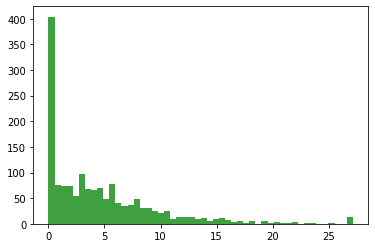

In [ ]:
nn, bins, patches = plt.hist(df_fr.Prediction, 50, facecolor ='g', alpha=0.75)
plt.show()

#fill data

In [ ]:
data = pd.read_csv(PATH_GDRIVE_TMP + "/test_overall_data_with_prediction_WN.csv")
# data = pd.read_csv(PATH_GDRIVE_TMP + "/test_overall_data_with_prediction_NN.csv")

In [ ]:
# data = pickle.load(open(PATH_GDRIVE_TMP+"/test_listings_overall.pkl", "rb"))
data.loc[df_fr.index, "Prediction"] = df_fr["Prediction"] 

In [ ]:
pickle.dump(data, open(PATH_GDRIVE_TMP + "/test_overall_data_with_prediction_NN.pkl", "wb"))
data.to_csv(PATH_GDRIVE_TMP+"/test_overall_data_with_prediction_NN.csv", index=False)

In [ ]:
pickle.dump(data, open(PATH_GDRIVE_TMP + "/test_data_with_prediction_WN.pkl", "wb"))
data.to_csv(PATH_GDRIVE_TMP+"/test_overall_data_with_prediction_WN.csv", index=False)